In [16]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [17]:
IMAGE_PATH = "../sample_images/monkey.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [18]:
def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save(f'{filename}.jpg')
    print(f'Saved as {filename}.jpg')

In [19]:
def plot_image(image, title=""):
    """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

In [20]:
import cv2


lr_image = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)
lr_image.shape

(120, 125, 3)

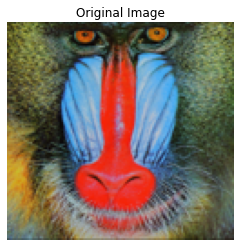

In [21]:
# Plotting Original Resolution image
plot_image(lr_image, title="Original Image")

In [22]:
from esrgan import ESRGAN


model = ESRGAN()
model.load()

new im shape (480, 500, 3)


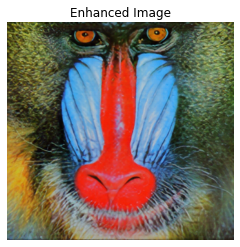

In [23]:
lr_images = tf.constant([lr_image], dtype=tf.float32)

for i, im in enumerate(model(lr_images)):
    print('new im shape', im.shape)
    im = tf.squeeze(im)
#     print('psnr', tf.image.psnr(lr_images[i], im, max_val=255))
    plot_image(tf.squeeze(im), title="Enhanced Image")

In [24]:
from json import load as json_load
from os import path

In [25]:
IMAGES_DIR = '../data/img'
LR_IMAGES_DIR = path.join(IMAGES_DIR, 'clear')
HR_IMAGES_DIR = path.join(IMAGES_DIR, 'degradated')
ANNOTATION_FILE_PATH = './data/annotation.json'

In [26]:
# from PIL import Image
# from os import unlink

# img_paths = glob(path.join(HR_IMAGES_DIR, '*'))
# c = 0
# for f in img_paths:
#     d, fname = path.split(f)
#     if 'degraded' in fname:
#         Image.open(f).save(path.join(d, fname.split('_')[-1]))
#         unlink(f)
#     c += 1

In [27]:
from abc import ABC, abstractmethod
from glob import glob


class SRDataset(ABC):
    lr_images_dir = None
    hr_images_dir = None
    batch_size = None
    
    def __iter__(self):
        lr_img_paths = glob(path.join(self.lr_images_dir, '*'))
        for i in range(0, len(lr_img_paths), self.batch_size):
            X, y = [], []
            for lr_img_fp in lr_img_paths[i:i + self.batch_size]:
                lr_image = cv2.cvtColor(cv2.imread(lr_img_fp), cv2.COLOR_BGR2RGB)
                _, file_name = path.split(lr_img_fp)

                hr_image = cv2.cvtColor(cv2.imread(path.join(self.hr_images_dir, file_name)), cv2.COLOR_BGR2RGB)
                
                X.append(cv2.resize(lr_image, (64, 64)))
                y.append(cv2.resize(hr_image, (256, 256)))

            yield tf.constant(X, tf.float32), tf.constant(y, tf.float32)


class DorianGrayTextDataset(SRDataset):
    def __init__(self, lr_images_dir, hr_images_dir, batch_size=32):
        self.lr_images_dir = lr_images_dir
        self.hr_images_dir = hr_images_dir
        self.batch_size = batch_size
    
    
dataset = DorianGrayTextDataset(LR_IMAGES_DIR, HR_IMAGES_DIR, batch_size=50)    
batch_x, batch_y = next(iter(dataset))

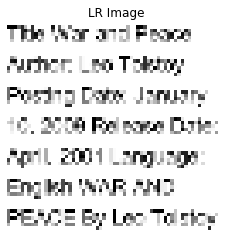

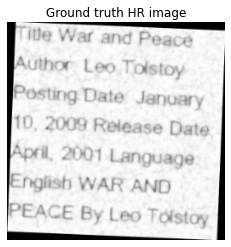

In [28]:
lr_image, hr_image = tf.squeeze(batch_x[0]).numpy(), tf.squeeze(batch_y[0]).numpy()
plot_image(lr_image, 'LR Image')
plt.figure()
plot_image(hr_image, 'Ground truth HR image')

(256, 256, 3)


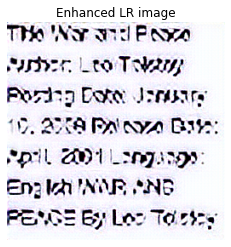

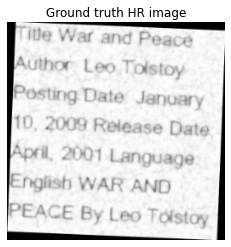

In [29]:
for i, img in enumerate(model(batch_x)):
    print(img.shape)
    plot_image(tf.squeeze(img), 'Enhanced LR image')
    plt.figure()
    plot_image(tf.squeeze(batch_y[i]), 'Ground truth HR image')
    break

In [30]:
mean_batch_psnr = 0.0

for batch_x, batch_y in dataset:
    mean_batch_psnr += cv2.PSNR(model(batch_x).numpy(), batch_y.numpy()) 

mean_batch_psnr /= dataset.batch_size
print('PSNR:', mean_batch_psnr)

PSNR: 29.46713099588469
